In [12]:
# libraries (imported in order of use in the notebook)
import mikeio
# simple simulation functionality: RunTimeEvaluation, Launcher
from mike_autocal.mikesimulation import RunTimeEvaluation, Launcher
# error tracking during runtime
from mike_autocal.dataio import ObservationData, SimObsPair, SimulationData
from mike_autocal.objective_fun import RMSEInnerMetric, AMEANOuterMetric
# automatic calibration 
import optuna
from mike_autocal.measurement_fun import ManningFile
from mike_autocal.autocal import AutoCal



# directories
from pathlib import Path
ROOT_DIR = Path().resolve()

# 1. Load and investigate setup

This demo is based on the [WaterBench Southern North Sea](https://github.com/DHI/WaterBench-MIKE21HD-SouthernNorthSea) model and observations.

To load the data we leverage `MIKEIO` and its pfs reading capabilities

In [13]:
# specify simulation setup file 
simfile = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/simulation/sns_base.m21fm"
# read with mikeio and display some information
pfs = mikeio.read_pfs(simfile)
pfs.FemEngineHD.TIME

Touched = 1
start_time = 2022, 1, 1, 0, 0, 0
time_step_interval = 600.0
number_of_time_steps = 500

# 2. Run simulation with simple logging

* simplest version with basic logging of runtime information (from stdout, interpolation in tensorboard if output frequency is lower than logging frequency)
* without utilizing observations


* introducting `RunTimeEvaluation` (RTE). 
    * Evaluates and generates logs with `TensorBoards` SummaryWriter (default is a timestamped directory like logs/simulation_YYYYMMDD_HHMMSS)
    * Logs can be found in `/teamspace/studios/this_studio/logs` and accessed via Tensorboard in real time.
    * frequency is the only argument that can be used in the RTE when no observation (SimObsPairs) are specified.
    * Logs will solely contain runtime information   
* introducing simulation `Launcher`
* introducing Tensorboard

In [3]:
rte = RunTimeEvaluation(frequency=50) # frequency of logging will be every 10 timesteps by default  

launcher = Launcher(
    simfile = simfile,      # path to simulation setup file
    use_gpu=True,           # use GPU if available
    runtimeevaluation=rte,  # Use an empty RunTimeEvaluation object
    n_cores = 1)
    
launcher.execute_simulation();

Processing: 100%|██████████| 500/500 [00:14<00:00, 34.34step/s]


# 2. Extend logging with error tracking from in-situ observations

* we need to link observations to simulation output
* introducing `SimObsPairs` 
* extended RTE allows for live tracking of specified error metrics

In [4]:
base_sim_path = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/simulation/sns_base.m21fm - Result Files"
base_obs_path = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/observations"

simobs = [
    SimObsPair(
        name="F3platform",
        pair_type="point",
        sim=SimulationData(
            file_path = base_sim_path / "waterlevels.dfs0",
            item=7,  
        ),
        obs=ObservationData(
            file_path = base_obs_path / "F3platform_wl.dfs0",
            item=0,  
        ),
    ),
    SimObsPair(
        name="Helgoland",
        pair_type="point",
        sim=SimulationData(
            file_path = base_sim_path / "waterlevels.dfs0",
            item=5,  
        ),
        obs=ObservationData(
            file_path = base_obs_path / "Helgoland_wl.dfs0",
            item=0,  
        ),
    ), # add as many as you want
    ]

using rte and the launcher once again, slightly extended.
* introducing `InnerMetric` as well as `OuterMetric`

In [5]:
rte = RunTimeEvaluation(simobs=simobs, 
                        inner_metric=[RMSEInnerMetric()], # can be multiple metrics as well (e.g. CC) 
                        outer_metric=[AMEANOuterMetric()], # defines how to aggregate data from multiple stations
                        frequency=50)


launcher = Launcher(
    simfile = simfile,      # path to simulation setup file
    use_gpu=True,           # use GPU if available
    runtimeevaluation=rte,  # Use new RunTimeEvaluation object
    n_cores = 1)
    
launcher.execute_simulation();

Processing: 100%|██████████| 500/500 [00:13<00:00, 36.40step/s]


# 3. Automatic calibration guided by error metrics

* introducing optuna
* optuna dashboard on log optuna-dashboard optuna_journal.log 
* introducing measurement functions


<Axes: title={'center': '2025-02-26 15:33:23'}, xlabel='Longitude [degrees]', ylabel='Latitude [degrees]'>

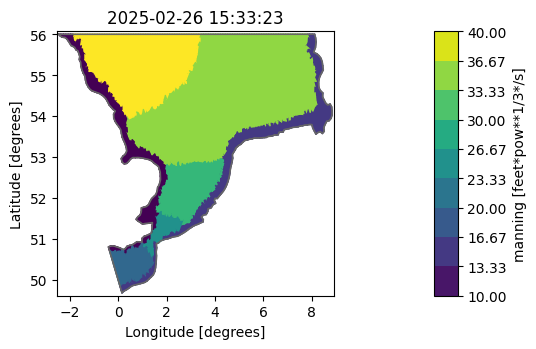

In [6]:
manningfile = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/simulation/conditions/ManningM.dfsu"
mikeio.read(manningfile)[0].plot()

In [10]:
sampler = optuna.samplers.GPSampler(seed=0) # which optimization algorithm to use (defaults to TPE)
evaluation_time = slice(50, None)           # at which time steps to evaluate the objective function (it can be a good idea to leave the swing-in period out)

inner_metric = [RMSEInnerMetric()] # can be multiple metrics as well (e.g. CC) 
outer_metric = [AMEANOuterMetric()] # defines how to aggregate data from multiple stations

direction = ["minimize"]                    # direction of optimization (see inner metric), can be multiobjective 
n_trials = 20                               # number of simulation runs in optimization
study_name = "testing_calibration"          # recognizable name


measurement_functions = [
    ManningFile(
        filename= manningfile,
        item_name="manning",
        low=0.001,
        high=81.101,
        step=0.01,
    )]

In [11]:
calibration = AutoCal(
    launcher=launcher,          # already contains simfile
    # add observations and metrics
    simobs=simobs,
    inner_metric=inner_metric,  
    outer_metric=outer_metric,
    # optimization settings
    study_name=study_name,
    n_trials=n_trials,
    direction=direction,
    sampler=sampler, 
    measurement_functions=measurement_functions,
    evaluation_time=evaluation_time,
    verbose=False,
    load_if_exists=True,
)
calibration.run()

[I 2025-05-16 09:35:01,721] Using an existing study with name 'testing_calibration' instead of creating a new one.
INFO:autocal:------------------------------------ Trial: 11 ------------------------------------


Processing: 100%|██████████| 500/500 [00:14<00:00, 35.47step/s]
INFO:autocal:InnerEvaluation(metric=RMSE):
              values    n
name                     
F3platform  0.262076  451
Helgoland   0.853893  451
[I 2025-05-16 09:35:19,149] Trial 11 finished with value: 0.5579843289756564 and parameters: {'Manning_0': 4.481, 'Manning_1': 0.0010000000000000009, 'Manning_2': 0.0010000000000000009, 'Manning_3': 33.79099999999999, 'Manning_4': 0.0010000000000000009, 'Manning_5': 5.761, 'Manning_6': 0.0010000000000000009}. Best is trial 11 with value: 0.5579843289756564.
INFO:autocal:------------------------------------ Trial: 12 ------------------------------------
Processing: 100%|██████████| 500/500 [00:13<00:00, 35.85step/s]
INFO:autocal:InnerEvaluation(metric=RMSE):
              values    n
name                     
F3platform  0.313605  451
Helgoland   0.808667  451
[I 2025-05-16 09:35:38,900] Trial 12 finished with value: 0.5611359788445969 and parameters: {'Manning_0': 52.70099999999

# 4. Evaluate simulations

* use optuna dataframe, 
* illustrate optimization based on simulation waterlevel (color sequentially by trial number)

In [7]:
file_path = "optuna_journal.log"
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(file_path)
)

study_name = "testing_calibration"  # Use the actual study name used when creating the study
study = optuna.load_study(study_name=study_name, storage=storage)

# 3. Convert the trials to a DataFrame
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_Manning_0,params_Manning_1,params_Manning_2,params_Manning_3,params_Manning_4,params_Manning_5,params_Manning_6,state
0,0,0.787042,2025-05-16 09:30:32.625572,2025-05-16 09:30:48.145720,0 days 00:00:15.520148,44.511,58.001,48.891,44.191,34.361,52.381,35.491,COMPLETE
1,1,0.812851,2025-05-16 09:30:48.147746,2025-05-16 09:31:02.826965,0 days 00:00:14.679219,72.331,78.161,31.101,64.211,42.891,46.071,75.071,COMPLETE
2,2,0.751182,2025-05-16 09:31:02.829283,2025-05-16 09:31:17.859436,0 days 00:00:15.030153,5.761,7.061,1.631,67.531,63.111,70.561,79.371,COMPLETE
3,3,0.739891,2025-05-16 09:31:17.861491,2025-05-16 09:31:32.451938,0 days 00:00:14.590447,64.811,37.431,63.301,9.591,51.901,11.621,76.621,COMPLETE
4,4,0.653499,2025-05-16 09:31:32.453820,2025-05-16 09:31:47.040175,0 days 00:00:14.586355,42.321,33.631,21.451,62.791,36.991,46.101,1.521,COMPLETE
5,5,0.810205,2025-05-16 09:31:47.042147,2025-05-16 09:32:01.748299,0 days 00:00:14.706152,50.091,49.641,50.031,76.541,55.301,29.151,35.441,COMPLETE
6,6,0.703885,2025-05-16 09:32:01.750115,2025-05-16 09:32:17.143745,0 days 00:00:15.393630,56.581,4.881,54.081,54.391,17.061,10.451,25.581,COMPLETE
7,7,0.677454,2025-05-16 09:32:17.146311,2025-05-16 09:32:32.258180,0 days 00:00:15.111869,29.501,46.241,35.571,80.161,8.271,16.941,13.081,COMPLETE
8,8,0.693899,2025-05-16 09:32:32.260158,2025-05-16 09:32:47.299542,0 days 00:00:15.039384,52.971,20.541,37.821,19.821,12.891,8.951,53.231,COMPLETE
9,9,0.635609,2025-05-16 09:32:47.301384,2025-05-16 09:33:02.656629,0 days 00:00:15.355245,11.201,15.941,29.901,66.591,7.871,67.961,7.791,COMPLETE


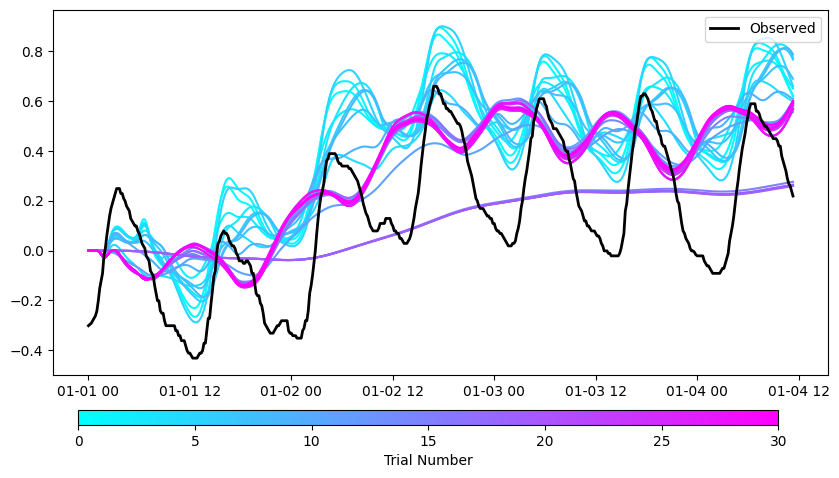

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
# use F3 platform observation and all simulations
base_obs_path = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/observations"
base_sim_path = ROOT_DIR / "mike_autocal/tests/data/simulation_data_sns/simulations"

fig, ax = plt.subplots(1,1,figsize=(10,5))

# Get a sequential colormap (cool)
cmap = cm.cool
trial_nums = df.number.values
norm = plt.Normalize(min(trial_nums), max(trial_nums))

# Clear any existing plots on the axis
ax.clear()

for i, tnum in enumerate(trial_nums):
    sim = mikeio.read(str(simfile).split(".")[0] + "_" + study_name + f"_trial_{tnum}.m21fm - Result Files/waterlevels.dfs0", items=["F3platform: Surface elevation"]).to_dataframe()
    # Use the colormap to assign colors based on trial number
    color = cmap(norm(tnum))
    
    # Plot without labels for trials
    ax.plot(sim.index, sim.values, color=color)

obs = mikeio.read(base_obs_path / "F3platform_wl.dfs0").to_dataframe()
# Plot observed data with explicit label
obs_line = ax.plot(obs.loc[sim.index].index, obs.loc[sim.index].values, c="black", linewidth=2)
ax.legend([obs_line[0]], ["Observed"], loc='upper right')

# Add a colorbar instead of a legend for trials
cax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # [left, bottom, width, height]
cb = ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label('Trial Number')

# Adjust figure to make room for colorbar
plt.subplots_adjust(bottom=0.15)